# Meng-Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.stattools import grangercausalitytests

from IPython.display import Image

Notebook ini merupakan lanjutan dari notebook sebelumnya. Isi dari Notebook ini antara lain feature engineering, exploratory data analysis(EDA), dan juga pembuatan model prediksi. 

# Membaca Dataset

In [2]:
df = pd.read_csv('data_kompes_fin.csv')

In [3]:
df.head()

date     Location  retail_and_recreation_percent_change_from_baseline  \
0  1/3/2020  DKI Jakarta                                                  4    
1  2/3/2020  DKI Jakarta                                                  6    
2  3/3/2020  DKI Jakarta                                                  3    
3  4/3/2020  DKI Jakarta                                                 -2    
4  5/3/2020  DKI Jakarta                                                  3    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                 10   
1                                                 24   
2                                                 17   
3                                                  4   
4                                                  8   

   parks_percent_change_from_baseline  \
0                                 -11   
1                                   5   
2                                  -1   
3                                  -8   
4                                   1   

   transit_stations_percent_change_from_baseline  \
0                                              6   
1                                              5   
2                                              3   
3                                              1   
4                                              4   

   workplaces_percent_change_from_baseline  \
0                                        6   
1                                        6   
2                                        5   
3                                        4   
4                                        5   

   residential_percent_change_from_baseline  New Cases  New Deaths  ...  \
0                                         0          2           0  ...   
1                                        -1          2           0  ...   
2                                         0          2           0  ...   
3                                         1          2           0  ...   
4                                         0          0           1  ...   

   Case Fatality Rate  Case Recovered Rate  Growth Factor of New Cases  \
0              51.28%              192.31%                         NaN   
1              48.78%              182.93%                         1.0   
2              46.51%              174.42%                         1.0   
3              44.44%              166.67%                         1.0   
4              46.67%              166.67%                         0.0   

   Growth Factor of New Deaths  pm10  so2  co  o3  no2  categori  
0                          NaN    45    5  13  28    8      BAIK  
1                          1.0    34    5  15  32   10      BAIK  
2                          1.0    59    5  23  29   14    SEDANG  
3                          1.0    56    7  19  55   16    SEDANG  
4                          NaN    35    6  16  30   13      BAIK  

[5 rows x 26 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 26 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                671 non-null    object 
 1   Location                                            671 non-null    object 
 2   retail_and_recreation_percent_change_from_baseline  671 non-null    int64  
 3   grocery_and_pharmacy_percent_change_from_baseline   671 non-null    int64  
 4   parks_percent_change_from_baseline                  671 non-null    int64  
 5   transit_stations_percent_change_from_baseline       671 non-null    int64  
 6   workplaces_percent_change_from_baseline             671 non-null    int64  
 7   residential_percent_change_from_baseline            671 non-null    int64  
 8   New Cases                                           671 non-null    int64  
 9  

## Penyesuaian Tipe & Manipulasi Data

Kami memanipulasi data, seperti perubahan tipe data, nama, dan nilai atau value data dengan tujuan agar proses kedepannya dapat dilakukan dengan lebih efisien.

In [5]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

df.set_index('date', inplace=True)

kolom 'date' kami ubah ke tipe time series untuk mempermudah visualisai line chart yang runtun pada bagian EDA.

In [6]:
df.rename(columns={'retail_and_recreation_percent_change_from_baseline':'retail_and_recreation',
                   'grocery_and_pharmacy_percent_change_from_baseline':'grocery_and_pharmacy',
                   'parks_percent_change_from_baseline':'parks',
                   'transit_stations_percent_change_from_baseline':'transit',
                   'workplaces_percent_change_from_baseline':'workplaces',
                   'residential_percent_change_from_baseline':'residential'}, inplace=True)

Penamaan yang panjang kami ubah menjadi lebih pendek guna mengefisienkan ruang baik pada bagian kode dan juga visalisasi

In [7]:
df.drop(['Growth Factor of New Cases', 'Growth Factor of New Deaths'], axis=1, inplace=True)

In [8]:
df['Case Fatality Rate'] = df['Case Fatality Rate'].str.replace('%', '').astype(float) / 100
df['Case Recovered Rate'] = df['Case Recovered Rate'].str.replace('%', '').astype(float) / 100

Terlihat di bagian informasi dataframe bahwa 'Case Fatality Rate' dan 'Case Recovered Rate' merupakan tipe data object, sehingga kami ubah ke bentuk decimal

In [9]:
df['pm10'] = df['pm10'].replace('---', np.nan)

In [10]:
df['pm10'] = df['pm10'].astype(float)

Pada kolom 'pm10' terdapat nilai '---' yang sebenarnya merupakan missing value, lalu terdapat kesalahan tipe data sehingga kami manipulasi '---' menjadi nan dan mengubah tipe data menjadi angka(float)

In [11]:
df = pd.get_dummies(df, columns=['categori'])

# EDA

## Pembuatan Fungsi untuk Visualisasi

Kami membuat fungsi untuk tiap kode visualisasi, untuk penghematan space dan juga efisiensi coding. 

In [12]:
def plot_time_series(data, date_column, value_columns, data_name, colour):
    # Determine the number of rows and columns for subplots
    num_plots = len(value_columns)
    num_cols = 2
    num_rows = (num_plots + 1) // 2

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(f'Plot Time Series {data_name}', fontsize=16)

    # Plot each time series in a separate subplot
    for i, column in enumerate(value_columns):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.plot(data.index, data[column], color=colour)
        ax.set_ylabel(column)
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Delete unused subplots if they exist
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axes.flatten()[i])

    # Adjust layout and spacing
    fig.tight_layout(rect=[0, 0, 1, 0.95], h_pad=2, w_pad=5)  # Adjust the h_pad and w_pad values as needed
    
    plt.show()

'plot_time_series' merupakan fungsi untuk memvisualisasikan beberapa fitur dalam bentuk time series.

In [13]:
def plot_time_series_uni(data, date_column, value_column, data_name, colour):

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[value_column])
    plt.ylabel(value_column)
    plt.title(f'Plot Time Series {data_name}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


'plot_time_series_uni' merupakan fungsi untuk memvisualisasikan satu fitur dalam bentuk time series.

In [14]:
def plot_time_series_multi(data, date_column, value_columns, target_columns, data_name, color_1, color_2):
    num_plots = len(value_columns)
    num_cols = 2
    num_rows = (num_plots + 1) // 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    fig.suptitle(f'Plot Time Series {data_name}', fontsize=16)

    for i, column in enumerate(value_columns):
        row = i // num_cols
        col = i % num_cols
        ax1 = axes[row, col]
        ax2 = ax1.twinx()

        ax1.plot(data[date_column], data[target_columns], label=target_columns, color=color_1)
        ax2.plot(data[date_column], data[column], label=column, color=color_2)

        ax1.set_ylabel(target_columns)
        ax2.set_ylabel(column)

        ax1.grid(True)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        ax1.tick_params(axis='x', rotation=45, labelsize=8)
        ax2.tick_params(axis='x', rotation=0, labelsize=8)

    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            fig.delaxes(axes[row, col])

    plt.show()


'plot_time_series_multi' merupakan fungsi untuk memvisualisasikan beberapa fitur yang didalamnya terdapat dua dua fitur sebagai komparasi satu sama laindalam bentuk time series.

In [15]:
def multi_hexplot(data, target_variable, features, color):
    num_features = len(features)
    num_cols = 3
    num_rows = (num_features + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        ax.hexbin(data[target_variable], data[feature], gridsize=25, cmap=color)
        ax.set_xlabel(target_variable)
        ax.set_ylabel(feature)
        ax.set_title(f'{target_variable} vs {feature}')

        slope, intercept, r_value, p_value, std_err = linregress(data[target_variable], data[feature])
        x = np.linspace(data[target_variable].min(), data[target_variable].max(), 100)
        y = slope * x + intercept
        ax.plot(x, y, color='red', linewidth=2)

    if num_features % num_cols != 0:
        for i in range(num_features, num_cols * num_rows):
            row = i // num_cols
            col = i % num_cols
            axes[row, col].axis('off')

    fig.tight_layout(rect=[0, 0, 1, 0.95], h_pad=2, w_pad=5)
    plt.show()

'multi_hexplot' merupakan fungsi untuk memvisualisasikan beberapa fitur dalam bentuk hexplot yang mencerminkan korelasi antar fitur.

In [16]:
color_covid = 'blue'
color_mobility = 'green'
color_air = 'red'

### Data COVID-19

Bagian ini berisi Visualisasi secara time series pada data yang berkaitan dengan COVID-19 dari tahun 2020-2021

In [17]:
covid_column = ['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 
                'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases',
                'Case Fatality Rate','Case Recovered Rate']

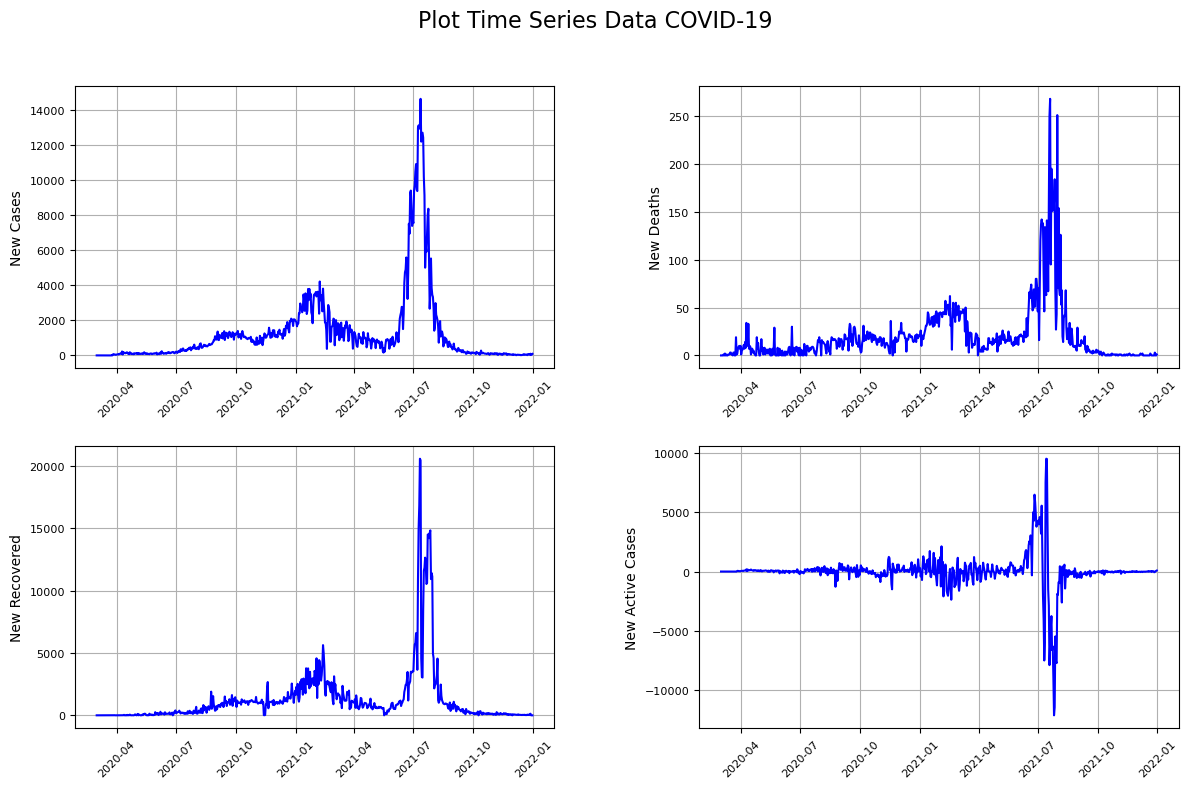

In [18]:
value_columns = ['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases']

plot_time_series(df, 'date', value_columns, 'Data COVID-19', color_covid)

Dari visualisasi diatas, dapat dilihat bahwa terdapat trend wabah covid-19 yang meningkat dari tahun awal tahun 2020 sampai awal tahun 2021, lalu reda dalam 5 bulan dan melalui lonjakan yang ekponensial pada bulan ke 7-8 tahun 2021 yang akhirnya mereda setelah 2-3 bulan berada di titik puncak 

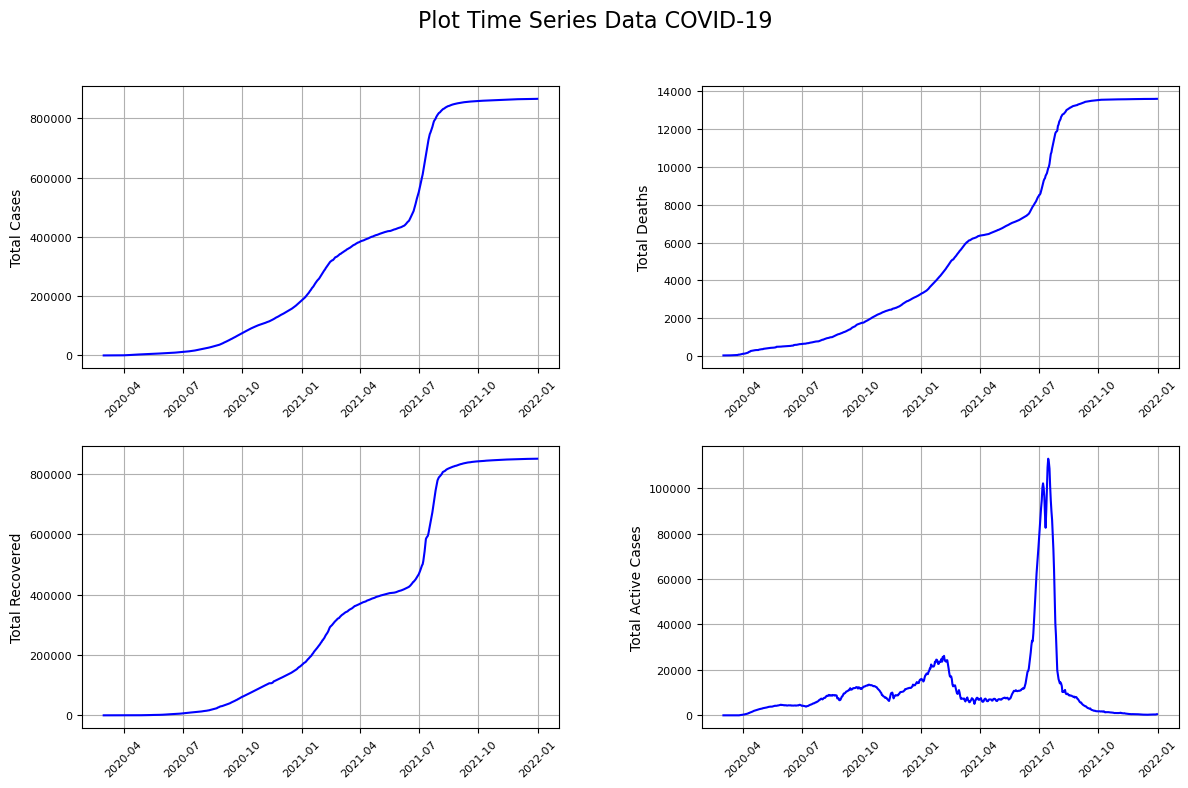

In [19]:
value2_columns = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases']

plot_time_series(df, 'date', value2_columns, 'Data COVID-19', color_covid)

Trend COVID-19 di DKI Jakarta juga dapat dilihat dari grafik diatas dimana gradien naik secara perlahan, kemudian mendatar, lalu naik secara tiba-tiba hingga kembali mendatar.

### Data Mobilitas

Bagian ini berisi Visualisasi secara time series pada data yang berkaitan dengan mobilitas di DKI Jakarta dari tahun 2020-2021

In [20]:
mobility_column = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks',
                   'transit', 'workplaces', 'residential']

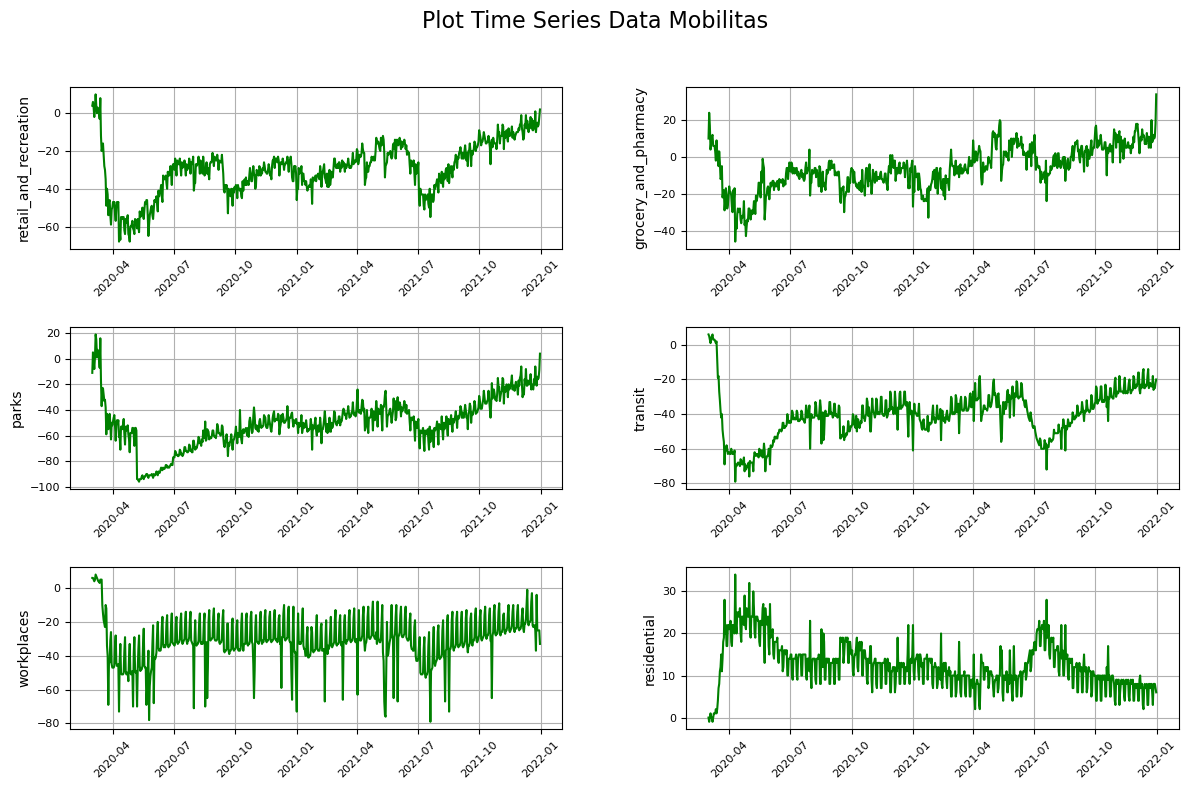

In [21]:
# Call the function to plot the time series
plot_time_series(df, 'date', mobility_column, 'Data Mobilitas', color_mobility)

Terlihat bahwa pada tiap jenis mobilitas memiliki trend yang hampir sama, walaupun tiap mobilitas memiliki karakteristiknya tersendiri.  Pada tiap jenis mobilitas (kecuali residential) hampir semua nilainya berada dibawah garis y=0, yang berarti mobilitas pada tiap sektor turun. Terdapat trend yang unik pada fitur workplaces, dimana terdapat lonjakan naik turun yang kentara, ini mungkin disebabkan oleh kebijakan WFH pada rentang waktu tersebut.

### Air Quality

Bagian ini berisi Visualisasi secara time series pada data yang berkaitan dengan polusi udara di DKI Jakarta dari tahun 2020-2021

In [22]:
Air_Quality_column = ['pm10', 'o3', 'no2', 'so2', 'co', 'categori']
pollution = ['pm10', 'o3', 'no2', 'so2', 'co']

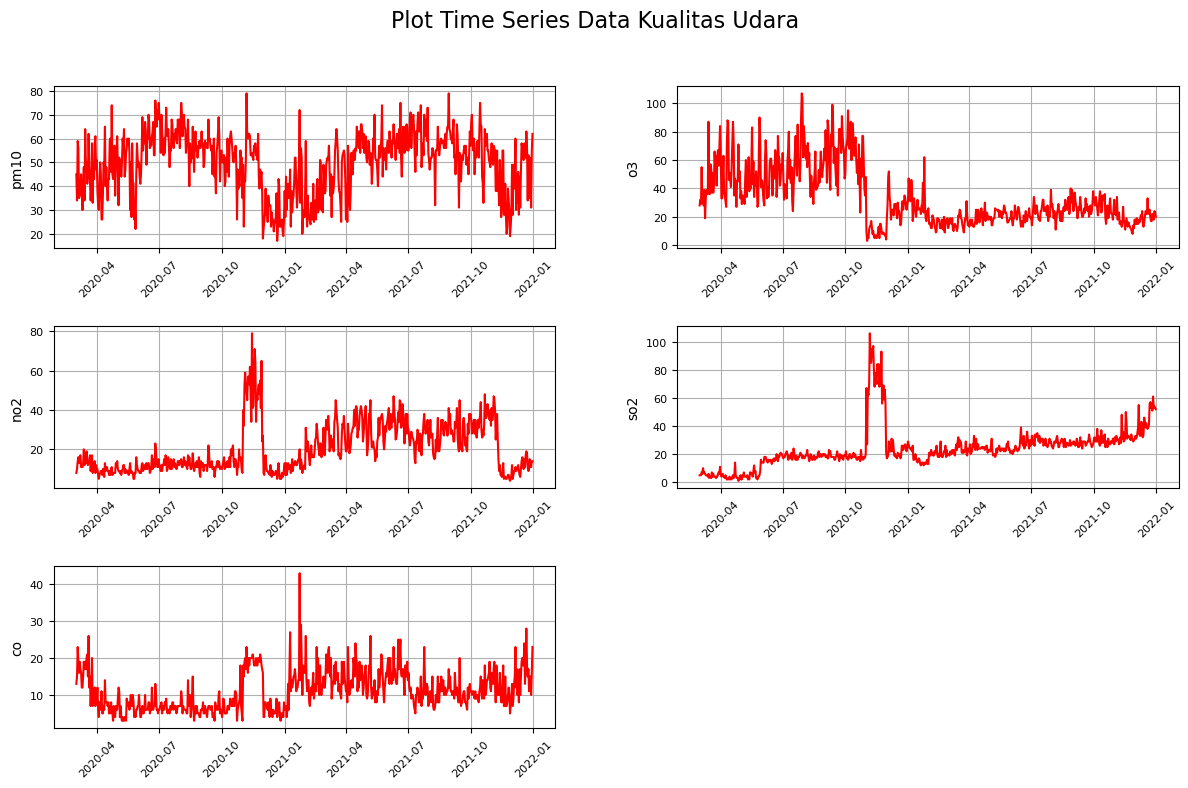

In [23]:
# Call the function to plot the time series
plot_time_series(df, 'date', pollution, 'Data Kualitas Udara', color_air)

Fitur CO, NO2, dan SO2 terlihat stabil dan juga memiliki trend yang mirip. Sedangkan fitur pm10 dan O3 terlihat memiliki data yang tidak stabil, akan tetapi keduanya tetap memiliki trend tersendiri . 

## Multivariable Analysis

### Covid >< Mobilitas

Pada bagian ini kami menganalis hubungan trend COVID-19 dengan mobilitas. Hipotesis kami adalah, wabah yang melonjak pada kurun waktu 2020-2021 seharusnya memengaruhi trend mobilitas di DKI Jakarta secara signifikan.

In [24]:
df2 = df.copy()
df2.reset_index(inplace=True)

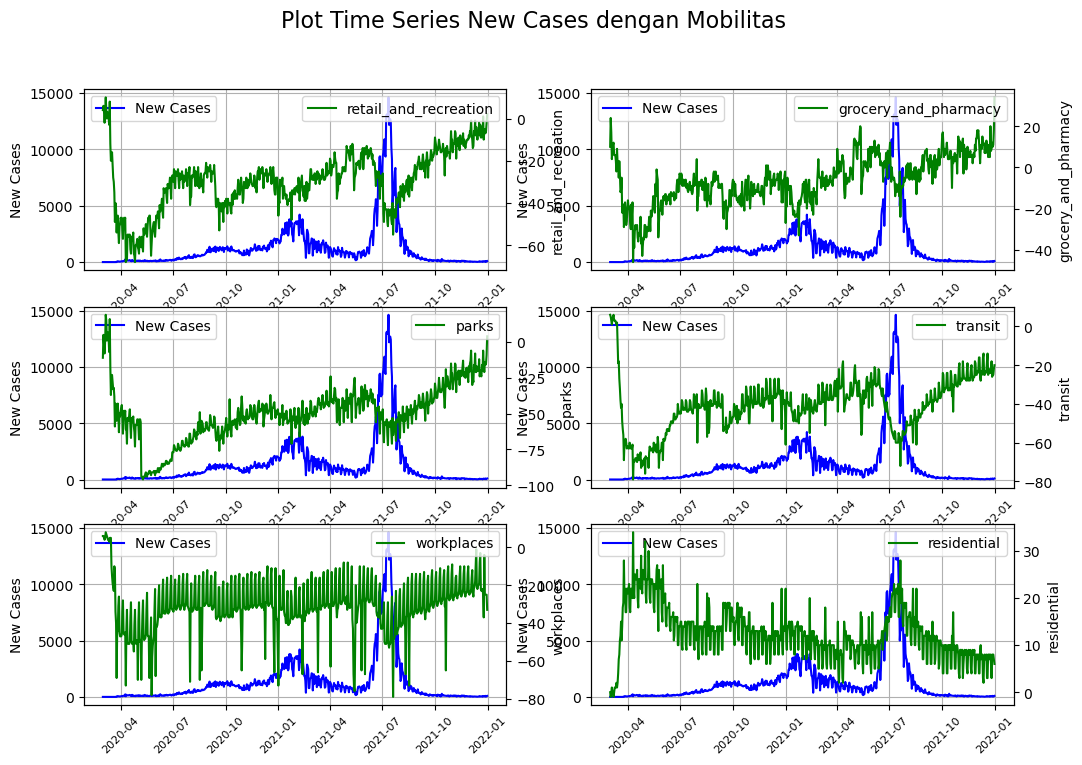

In [25]:
plot_time_series_multi(df2, 'date', mobility_column, 'New Cases', 'New Cases dengan Mobilitas',color_covid, color_mobility)

Dapat diambil informasi secara visual bahwa Kasus wabah COVID-19 memberi dampak terhadap trend mobilitas di beberapa sektor di wilayah DKI Jakarta. Terlihat jelas di sekitar bulan ke-y tahun 2021 dimana wabah COVID-19 melonjak tinggi, semua sektor mobilitas (kecuali residential) juga melonjak turun.

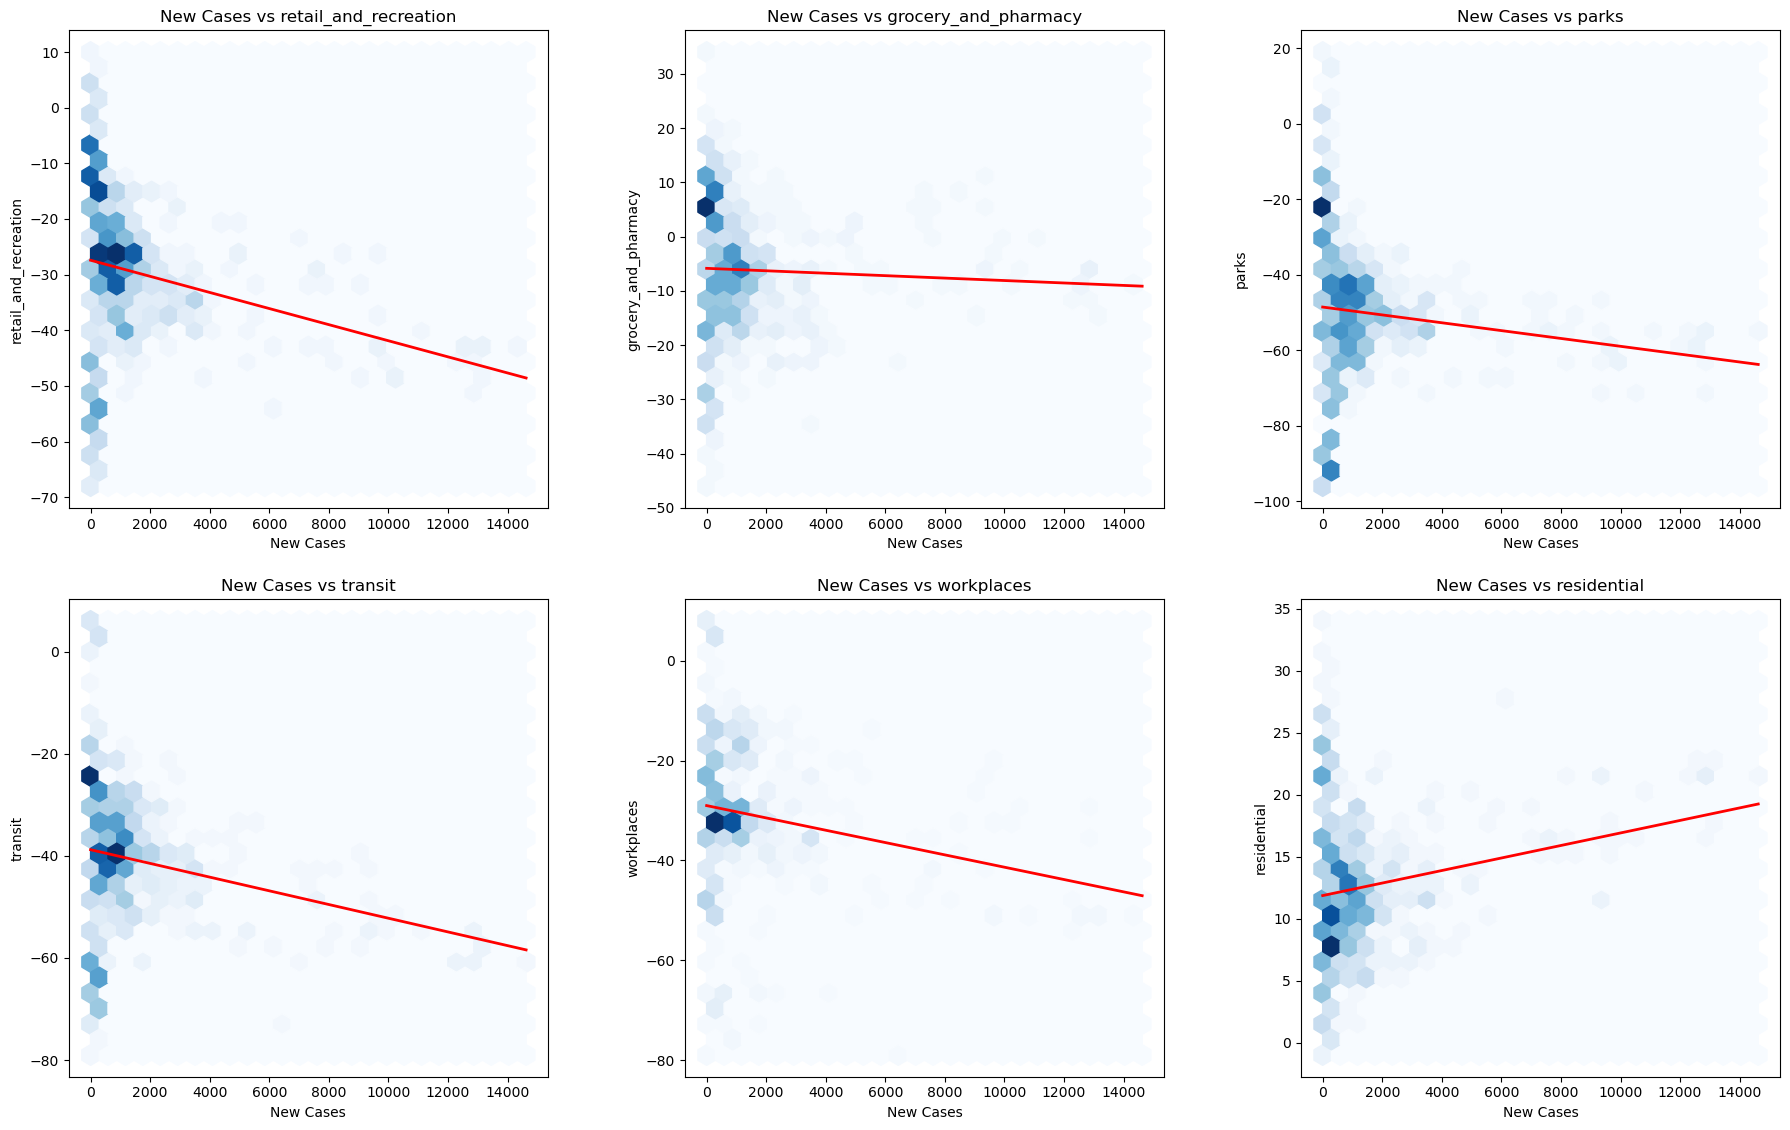

In [26]:
multi_hexplot(df2, "New Cases", mobility_column, 'Blues')

Visualisasi diatas merupakan Hexplot dimana memberi informasi mengenai hubungan/persebaran 2 fitur tanpa memperhatikan time series. Terlihat bahwa antar fitur pada tiap plot tidak menunjukkan hubungan yang sangat erat, akan tetapi tetap terdapat sebuah ... yang mampu mendekati relasi dari kedua fitur. 

### Mobilitas >< Polusi Udara

Pada bagian ini kami menganalis hubungan trend mobilitas dengan Polusi Udara. Hipotesis kami adalah, dikarenakan trend mobilitas yang terdampak oleh wabah COVID-19, seharusnya kualitas udara di DKI Jakarta, yang merupakan kota dengan kepadatan dan mobilitas yang tinggi, membaik secara signifikan.  

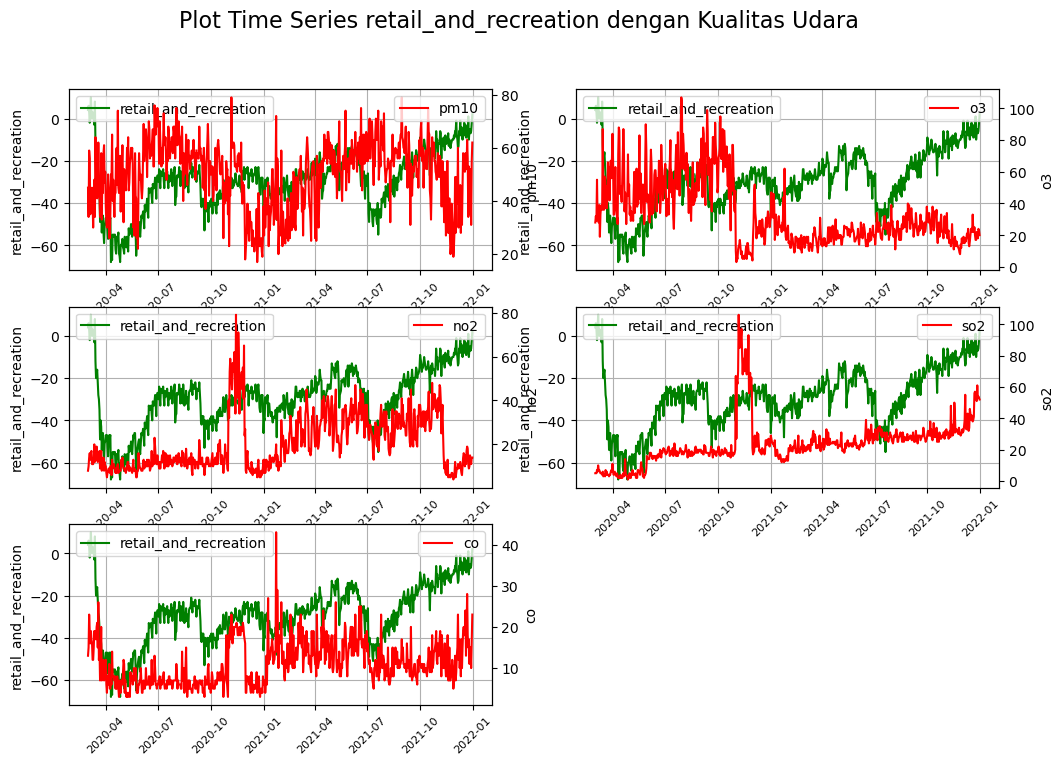

In [27]:
plot_time_series_multi(df2, 'date', pollution, 'retail_and_recreation', 'retail_and_recreation dengan Kualitas Udara',color_mobility, color_air)

secara visual tren antar variabel pada grafik-grafik diatas susah untuk diinferensikan. Oleh karena itu, akan kami gunakan pendekatan kualitatif untuk mengambil informasi hubungan antar variabel dalam pendekatan time-series.

# Data Preprocessing

## Missing Value

In [28]:
print(df.isnull().sum()/len(df)*100)

Location                 0.000000
retail_and_recreation    0.000000
grocery_and_pharmacy     0.000000
parks                    0.000000
transit                  0.000000
workplaces               0.000000
residential              0.000000
New Cases                0.000000
New Deaths               0.000000
New Recovered            0.000000
New Active Cases         0.000000
Total Cases              0.000000
Total Deaths             0.000000
Total Recovered          0.000000
Total Active Cases       0.000000
Case Fatality Rate       0.000000
Case Recovered Rate      0.000000
pm10                     0.149031
so2                      0.000000
co                       0.000000
o3                       0.000000
no2                      0.000000
categori_BAIK            0.000000
categori_SEDANG          0.000000
categori_TIDAK SEHAT     0.000000
dtype: float64


Ditemukan missing value pada kolom pm10 sebesar 14.9% data. Missing value perlu dilakukan imputasi atau penghapusan baris, dikarenakan banyak model machine learning tidak dapat mentolerir missing value pada komputasinya.

c:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


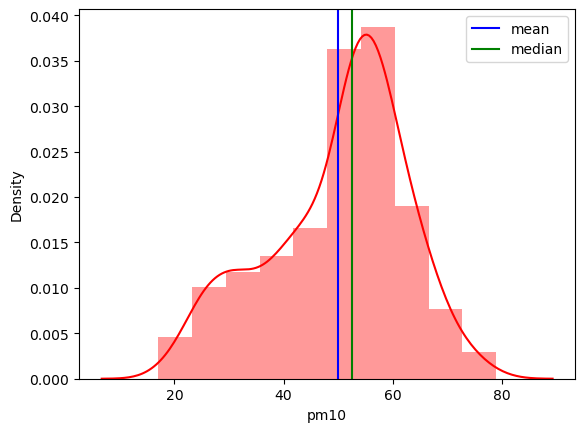

In [29]:
sns.distplot(df['pm10'], bins=10, kde=True, color='red')

plt.axvline(df['pm10'].mean(), color='blue', label='mean')
plt.axvline(df['pm10'].median(), color='green', label='median')
plt.legend()
plt.show()

In [30]:
df['pm10'].fillna(df['pm10'].mean(), inplace=True)

Missing value pada kolom pm10 kami imputasi dengan menggunakan nilai mean atau rerata dikarenakan nilai mean lebih mendekati titik distribusi data pm10.

# Granger Causality Test

Kami menggunakan Granger causality untuk menentukan apakah suatu variabel dalam sudut pandang time-series dapat mempengaruhi variabel lainnya berdasarkan asumsi bahwa jika suatu variabel A secara signifikan dapat digunakan untuk memprediksi variabel B dalam jangka waktu tertentu, dan prediksi tersebut tidak terjadi sebaliknya, maka dapat dikatakan bahwa variabel A "Granger-cause" variabel B yang mengindikasikan ada ketergantungan antar 2 variabel tersebut

Salah satu output dari GCT adalah P-value. P-value yang lebih kecil menunjukkan bukti yang lebih kuat terhadap adanya hubungan kausal, sedangkan p-value yang lebih besar menunjukkan bukti yang lebih lemah atau tidak ada bukti yang cukup untuk mendukung adanya hubungan kausal. Kami menggunakan threshold 0.05 untuk menyatakan bahwa terdapat hubungan antar variabel

In [31]:
print(covid_column)
print(mobility_column)
print(Air_Quality_column)

['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases', 'Case Fatality Rate', 'Case Recovered Rate']
['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit', 'workplaces', 'residential']
['pm10', 'o3', 'no2', 'so2', 'co', 'categori']


In [32]:
Air_Quality_column2 = ['pm10', 'o3', 'no2', 'so2', 'co']

In [33]:
for column in covid_column:
    for column2 in mobility_column:
        print(f'Does {column} granger causing {column2}?')
        print(grangercausalitytests(df[[column2, column]], maxlag=7))
        print('==========================================')
        print('\n')

Does New Cases granger causing retail_and_recreation?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9867  , p=0.1592  , df_denom=667, df_num=1
ssr based chi2 test:   chi2=1.9956  , p=0.1578  , df=1
likelihood ratio test: chi2=1.9926  , p=0.1581  , df=1
parameter F test:         F=1.9867  , p=0.1592  , df_denom=667, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2342  , p=0.2917  , df_denom=664, df_num=2
ssr based chi2 test:   chi2=2.4870  , p=0.2884  , df=2
likelihood ratio test: chi2=2.4824  , p=0.2890  , df=2
parameter F test:         F=1.2342  , p=0.2917  , df_denom=664, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2252  , p=0.2996  , df_denom=661, df_num=3
ssr based chi2 test:   chi2=3.7144  , p=0.2940  , df=3
likelihood ratio test: chi2=3.7041  , p=0.2952  , df=3
parameter F test:         F=1.2252  , p=0.2996  , df_denom=661, df_num=3

Granger Causality
number of lags (no ze

In [34]:
for column in mobility_column:
    for column2 in Air_Quality_column2:
        print(f'Does {column} granger causing {column2}?')
        print(grangercausalitytests(df[[column2, column]], maxlag=7))
        print('==========================================')
        print('\n')

Does retail_and_recreation granger causing pm10?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0071  , p=0.9328  , df_denom=667, df_num=1
ssr based chi2 test:   chi2=0.0072  , p=0.9326  , df=1
likelihood ratio test: chi2=0.0072  , p=0.9326  , df=1
parameter F test:         F=0.0071  , p=0.9328  , df_denom=667, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4457  , p=0.2363  , df_denom=664, df_num=2
ssr based chi2 test:   chi2=2.9131  , p=0.2330  , df=2
likelihood ratio test: chi2=2.9068  , p=0.2338  , df=2
parameter F test:         F=1.4457  , p=0.2363  , df_denom=664, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6634  , p=0.5748  , df_denom=661, df_num=3
ssr based chi2 test:   chi2=2.0112  , p=0.5701  , df=3
likelihood ratio test: chi2=2.0082  , p=0.5707  , df=3
parameter F test:         F=0.6634  , p=0.5748  , df_denom=661, df_num=3

Granger Causality
number of lags (no zero) 4

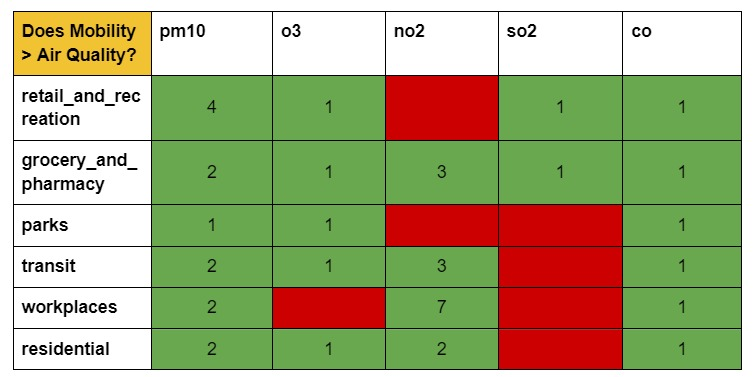

In [61]:
Image(filename='GCT.jpeg')

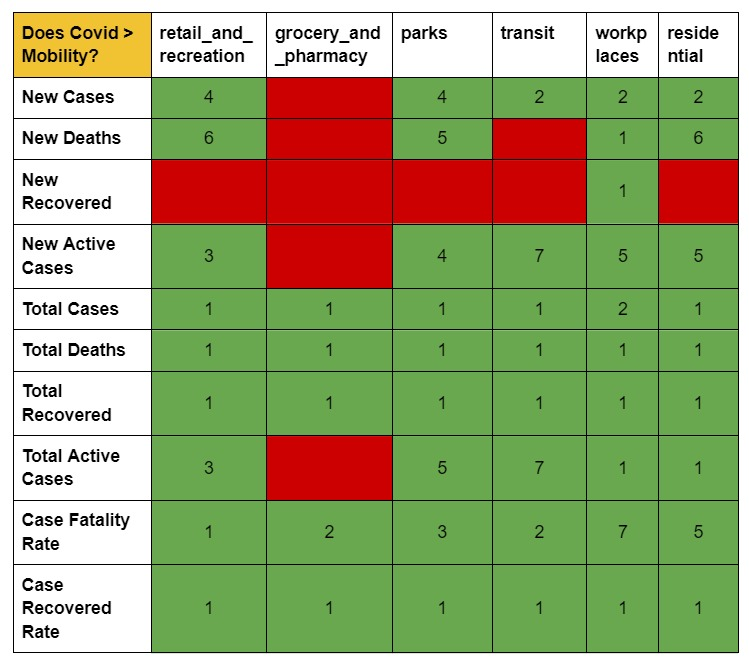

In [60]:
Image(filename='GCT 2.jpeg')

Kedua tabel diatas adalah hasil dari GCT. Latar belakang hijau menyatakan bahwa tersapat hubungan kausalitas antar variabel, dengan angka yang 1-7 yang mengindikasikan pada lag keberapa p value mencapai < 0.05. Sedangkan latar belakang merah menyatakan nilai p-value tidak mencapai < 0.05 pada akhir lag ke 7. 

# Modelling

## Mobility Prediction Based on Covid Dataset

## Penentuan Variabel

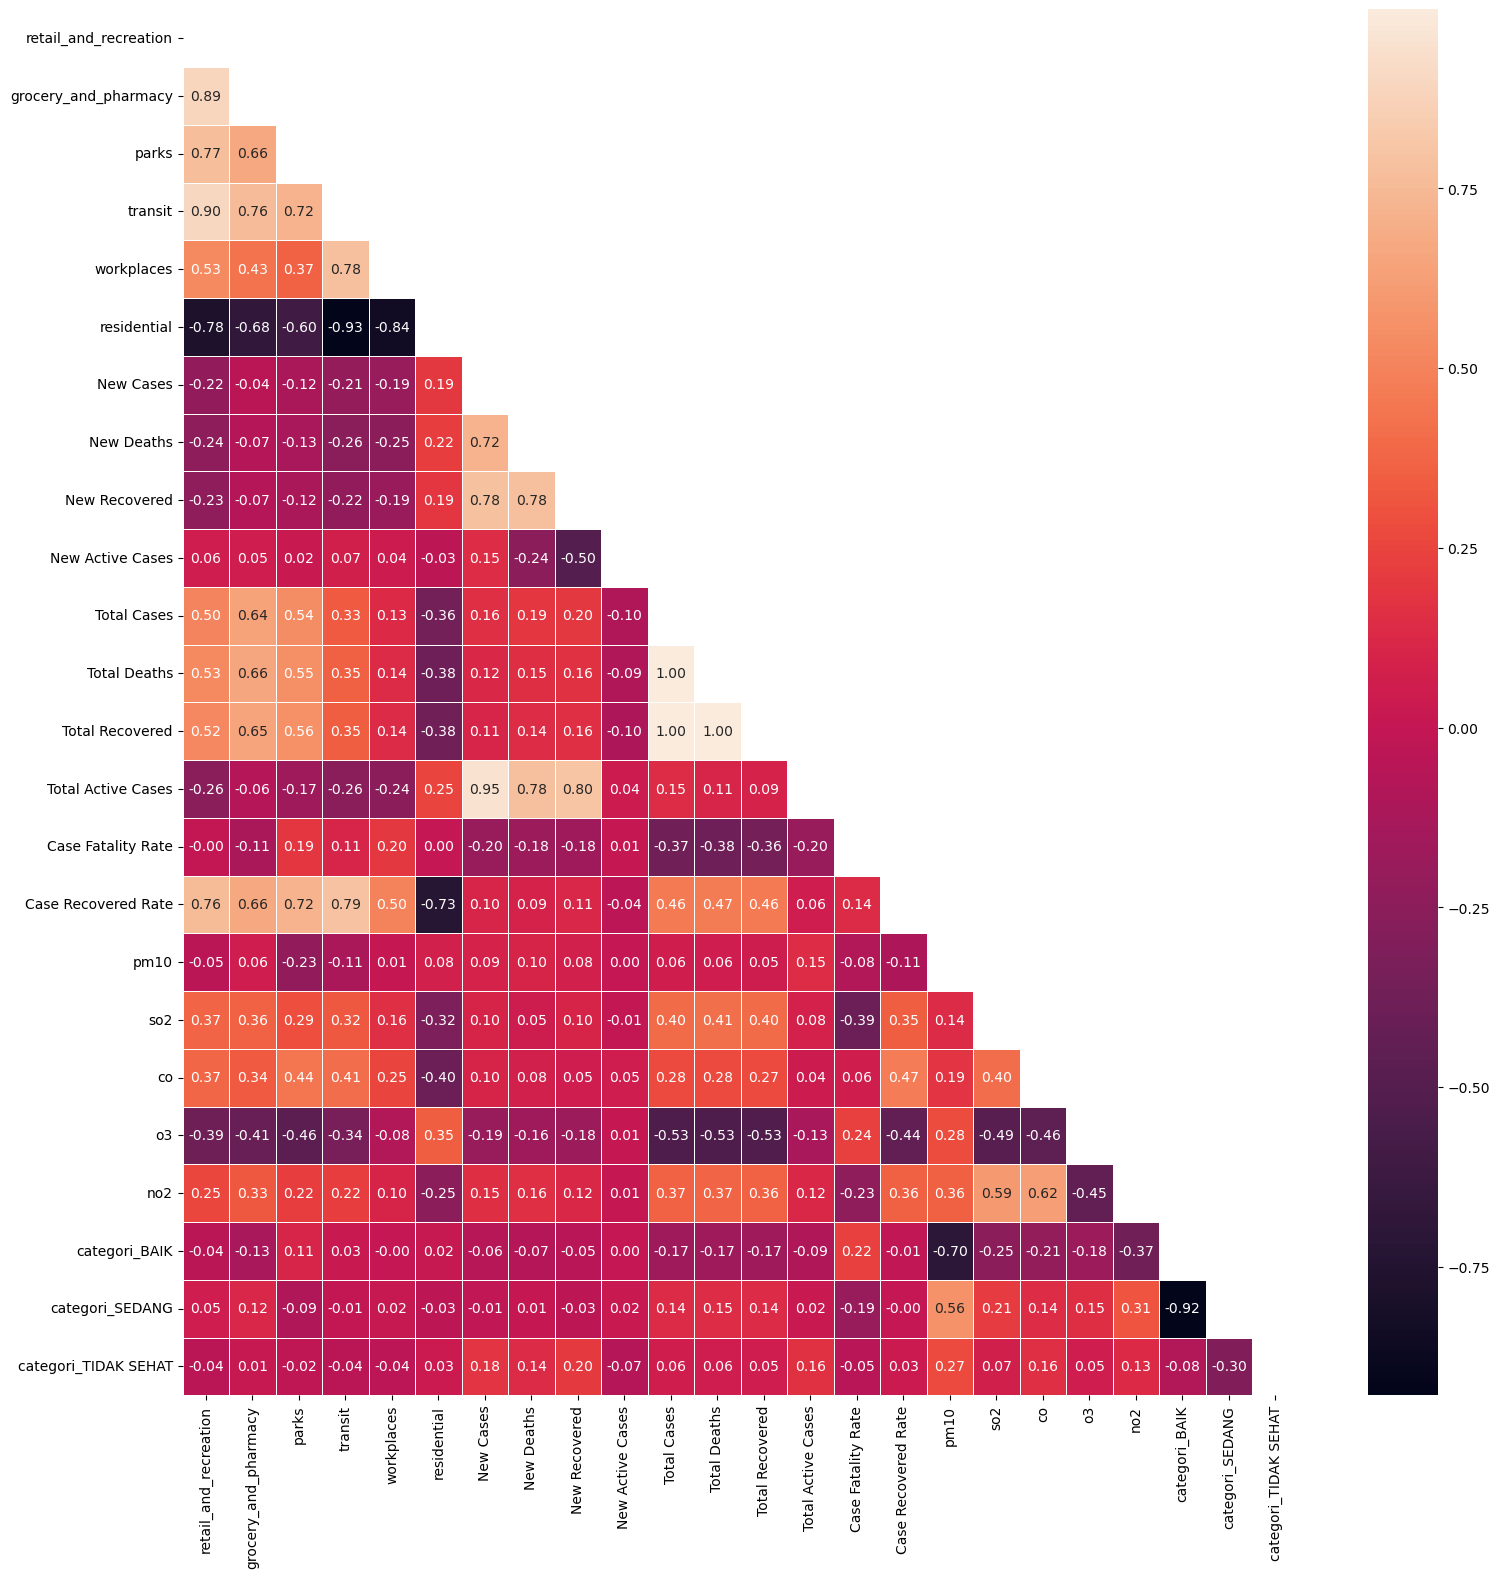

In [35]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt='.2f', ax=ax, mask=mask)
plt.show()

### Matriks Korelasi Covid >< Mobilitas

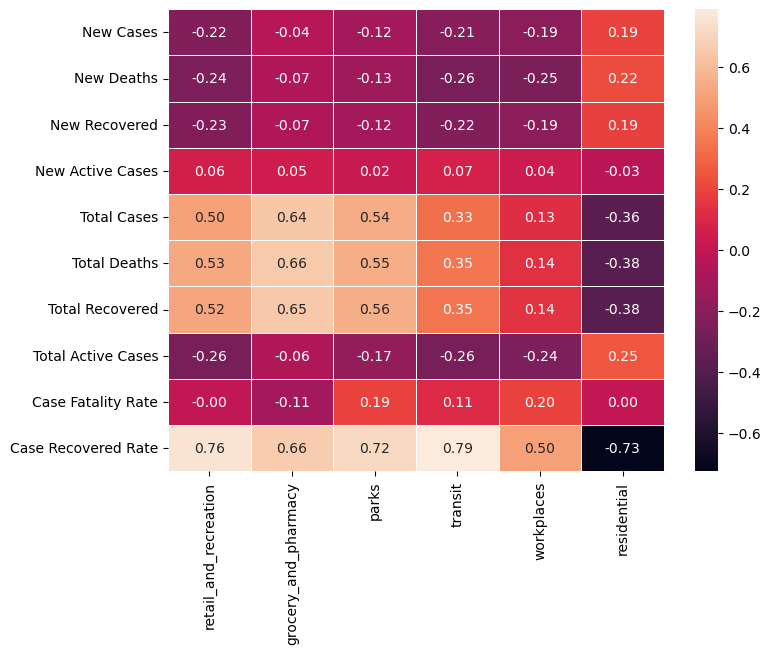

In [36]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.loc[covid_column, mobility_column], annot=True, linewidths=.5, fmt='.2f')
plt.show()

Dari matriks korelasi diatas terlihat bahwa kolom "Case recovered Rate", "Total Cases", "Total Death", "Total Recovered" memiliki korelasi yang tinggi dengan data mobilitas pada tiap tipe. Terlihat juga bahwa kolom "Total Cases", "Total Death", "Total Recovered" memiliki tren yang sama dan bahkan memiliki nilai korelasi 1 pada hubungan ketiganya. Selain itu, kolom "New Cases", "New Death", "New Recovered", dan "Total Active Cases" juga memiliki nilai korelasi yang mirip ke setiap data mobilitas, walaupun nilai korelasi ketiganya tidak mencapai 1. Oleh karena itu, kami akan memilih beberapa kolom saja dari data covid untuk memprediksi data mobilitas, yakni "Case Recovered Rate", "Total Deaths", dan "Total Active Cases".

### Matriks Korelasi Mobilitas >< Polusi

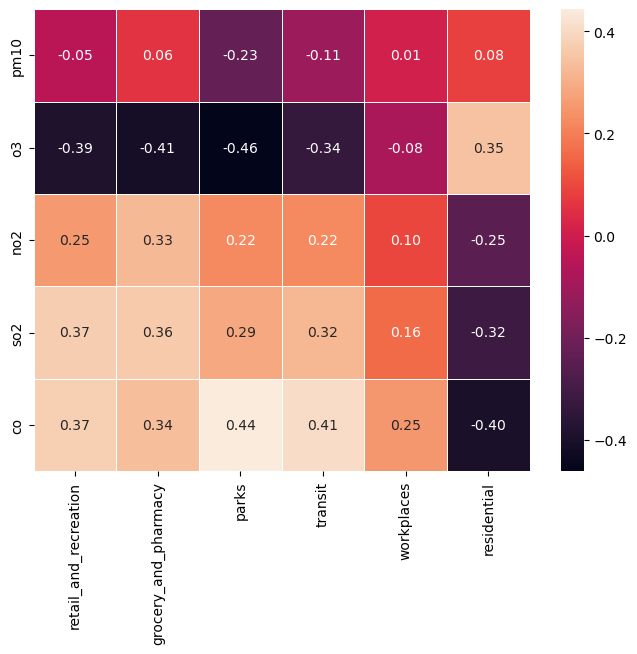

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.loc[Air_Quality_column2, mobility_column], annot=True, linewidths=.5, fmt='.2f')
plt.show()

Dapat diinferensikan bahwa terdapat tipe polusi memiliki kecenderungan korelasi yang spesifik. Contohnya, 'pm10' lebih terikat dengan mobilitas 'parks' dibandingkan dengan tipe mobilitas lainnya. Namun, terdapat juga kolom seperti 'co' yang memiliki kecenderungan yang lebih merata.

## Prediksi Mobilitas Berdasarkan Data COVID-19

In [38]:
X = df[["Case Recovered Rate", "Total Deaths", "Total Active Cases"]]
y_1 = df['retail_and_recreation']
y_2 = df['grocery_and_pharmacy']
y_3 = df['parks']
y_4 = df['transit']
y_5 = df['workplaces']
y_6 = df['residential']

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X, y_1, test_size=0.3, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X, y_2, test_size=0.3, random_state=42)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X, y_3, test_size=0.3, random_state=42)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X, y_4, test_size=0.3, random_state=42)
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X, y_5, test_size=0.3, random_state=42)
X_6_train, X_6_test, y_6_train, y_6_test = train_test_split(X, y_6, test_size=0.3, random_state=42)

In [39]:
X_train = [X_1_train, X_2_train, X_3_train, X_4_train, X_5_train, X_6_train]
y_train = [y_1_train, y_2_train, y_3_train, y_4_train, y_5_train, y_6_train]
X_test = [X_1_test, X_2_test, X_3_test, X_4_test, X_5_test, X_6_test]
y_test = [y_1_test, y_2_test, y_3_test, y_4_test, y_5_test, y_6_test]

Kami akan membuat 3 jenis model prediksi, yakni prediksi dengan Regresi Linear, XGBoost, dan XGBoost dengan automatic hyperparameter tuning.

### Linear Regression

In [40]:
regressors = [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]

mse_linear_values = []
y_pred_linear_values = []

for i in range(len(regressors)):
    regressors[i].fit(X_train[i], y_train[i])
    y_pred = regressors[i].predict(X_test[i])
    y_pred_linear_values.append(y_pred)
    mse = mean_squared_error(y_test[i], y_pred)
    mse_linear_values.append(mse)
    print(f"Mean squared error for {mobility_column[i]}: %.2f" % mse)

Mean squared error for retail_and_recreation: 56.90
Mean squared error for grocery_and_pharmacy: 62.19
Mean squared error for parks: 145.61
Mean squared error for transit: 59.62
Mean squared error for workplaces: 129.55
Mean squared error for residential: 13.35


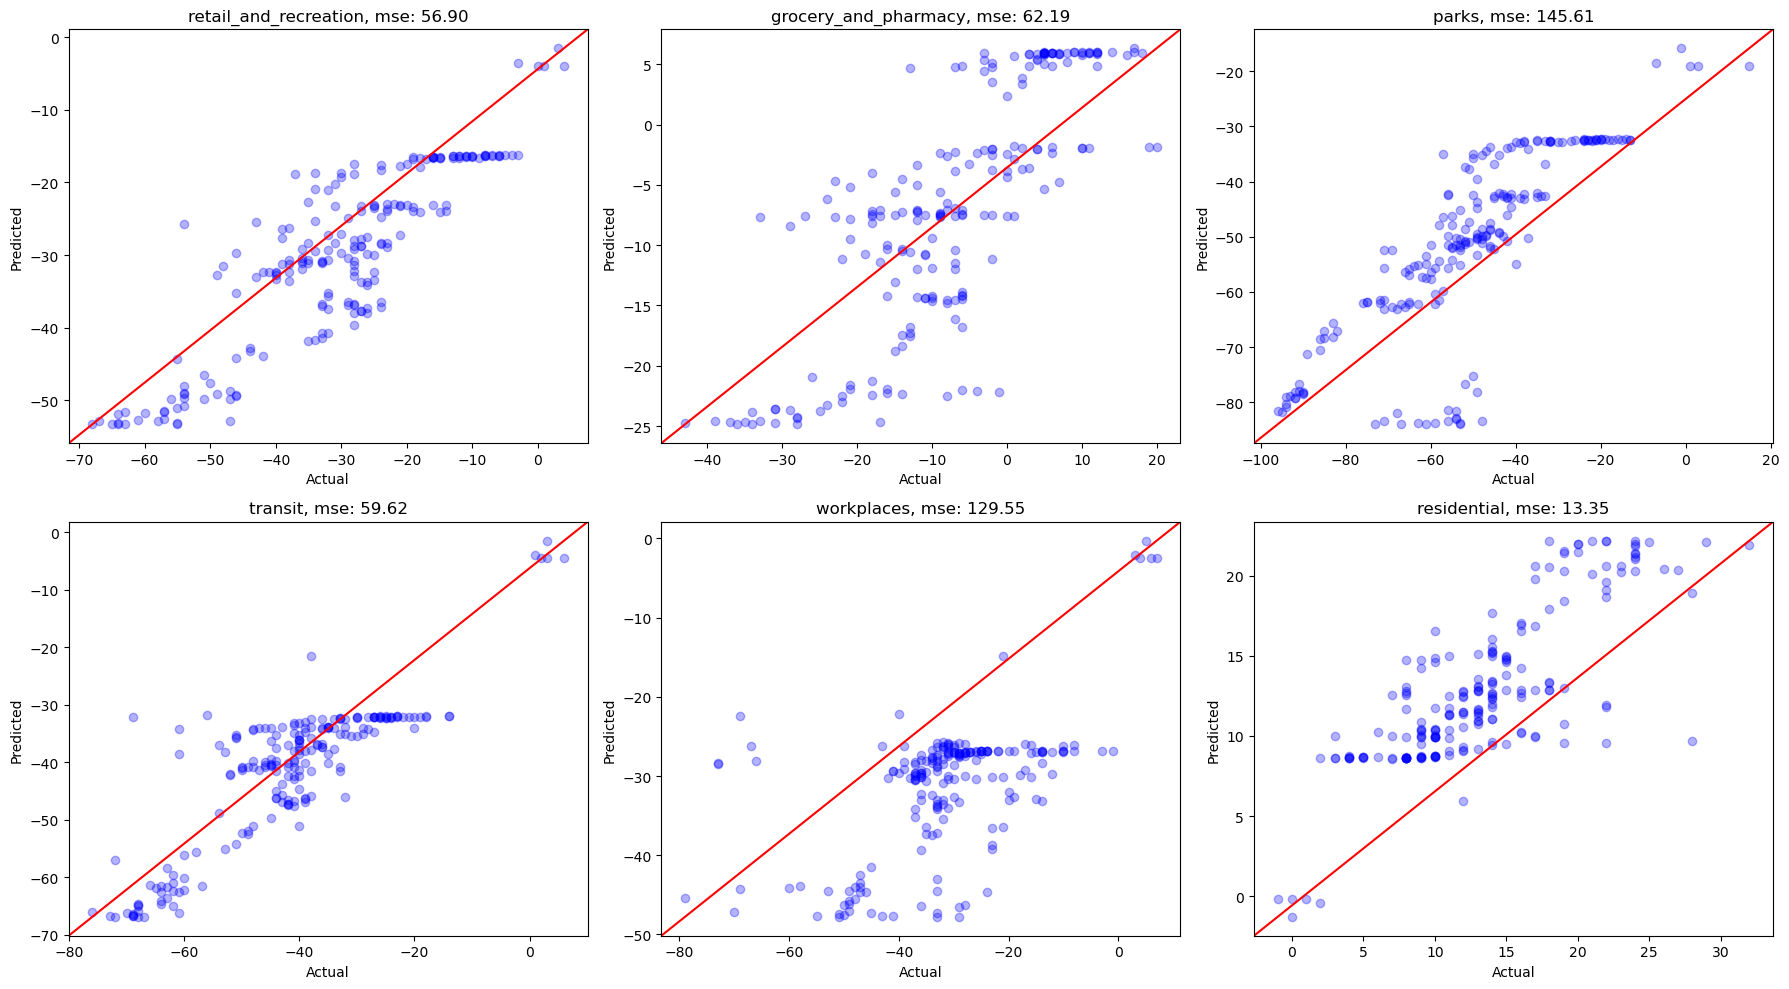

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_linear = [y_pred_linear_values, y_test]

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[i], y_pred_linear_values[i], c='blue', alpha=0.3)
    ax.plot([y_test[i].min(), y_test[i].max()], [y_test[i].min(), y_test[i].max()], c='red', transform=ax.transAxes)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(mobility_column[i] + ", mse: %.2f" % mse_linear_values[i])

plt.tight_layout()
plt.show()

### XGBoost

In [42]:
regressors = [XGBRegressor(), XGBRegressor(), XGBRegressor(), XGBRegressor(), XGBRegressor(), XGBRegressor()]

mse_xgb_values = []
y_pred_xgb_values = []

for i in range(len(regressors)):
    regressors[i].fit(X_train[i], y_train[i])
    y_pred = regressors[i].predict(X_test[i])
    y_pred_xgb_values.append(y_pred)
    mse = mean_squared_error(y_test[i], y_pred)
    mse_xgb_values.append(mse)
    print(f"Mean squared error for {mobility_column[i]}: %.2f" % mse)


Mean squared error for retail_and_recreation: 27.83
Mean squared error for grocery_and_pharmacy: 41.86
Mean squared error for parks: 39.29
Mean squared error for transit: 23.76
Mean squared error for workplaces: 143.79
Mean squared error for residential: 13.14


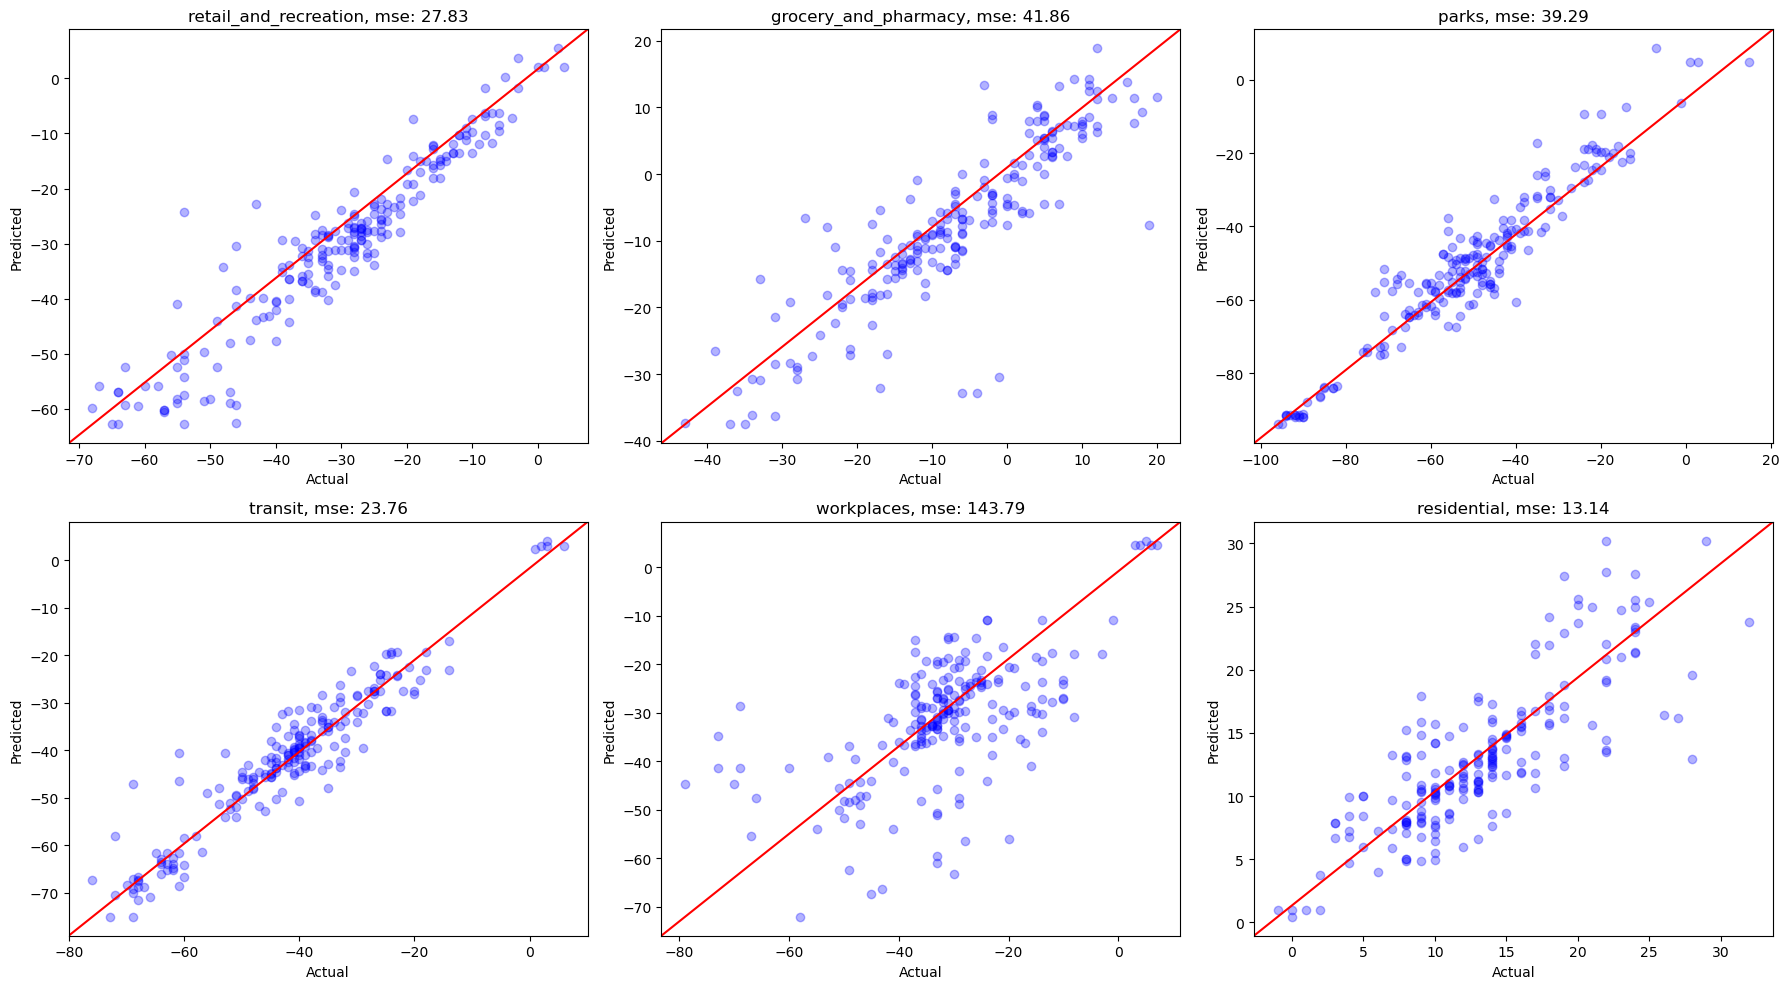

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_xgb = [y_pred_xgb_values, y_test]

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[i], y_pred_xgb_values[i], c='blue', alpha=0.3)
    ax.plot([y_test[i].min(), y_test[i].max()], [y_test[i].min(), y_test[i].max()], c='red', transform=ax.transAxes)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(mobility_column[i] + ", mse: %.2f" % mse_xgb_values[i])

plt.tight_layout()
plt.show()

### XGBoost With Hyperparameter Tuning

In [44]:
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
}

mse_xgb_tuning_values = []
y_pred_xgb_tuning_values = []

for i in range(len(regressors)):
    grid_search = GridSearchCV(regressors[i], param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train[i], y_train[i])
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test[i])
    y_pred_xgb_tuning_values.append(y_pred)
    mse = mean_squared_error(y_test[i], y_pred)
    mse_xgb_tuning_values.append(mse)
    print(f"Best parameters for {mobility_column[i]}: {grid_search.best_params_}")
    print(f"Mean squared error for {mobility_column[i]}: {mse:.2f}")

Best parameters for retail_and_recreation: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
Mean squared error for retail_and_recreation: 16.51
Best parameters for grocery_and_pharmacy: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}
Mean squared error for grocery_and_pharmacy: 33.23
Best parameters for parks: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
Mean squared error for parks: 31.37
Best parameters for transit: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Mean squared error for transit: 20.38
Best parameters for workplaces: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Mean squared error for workplaces: 112.36
Best parameters for residential: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Mean squared error for residential: 10.78


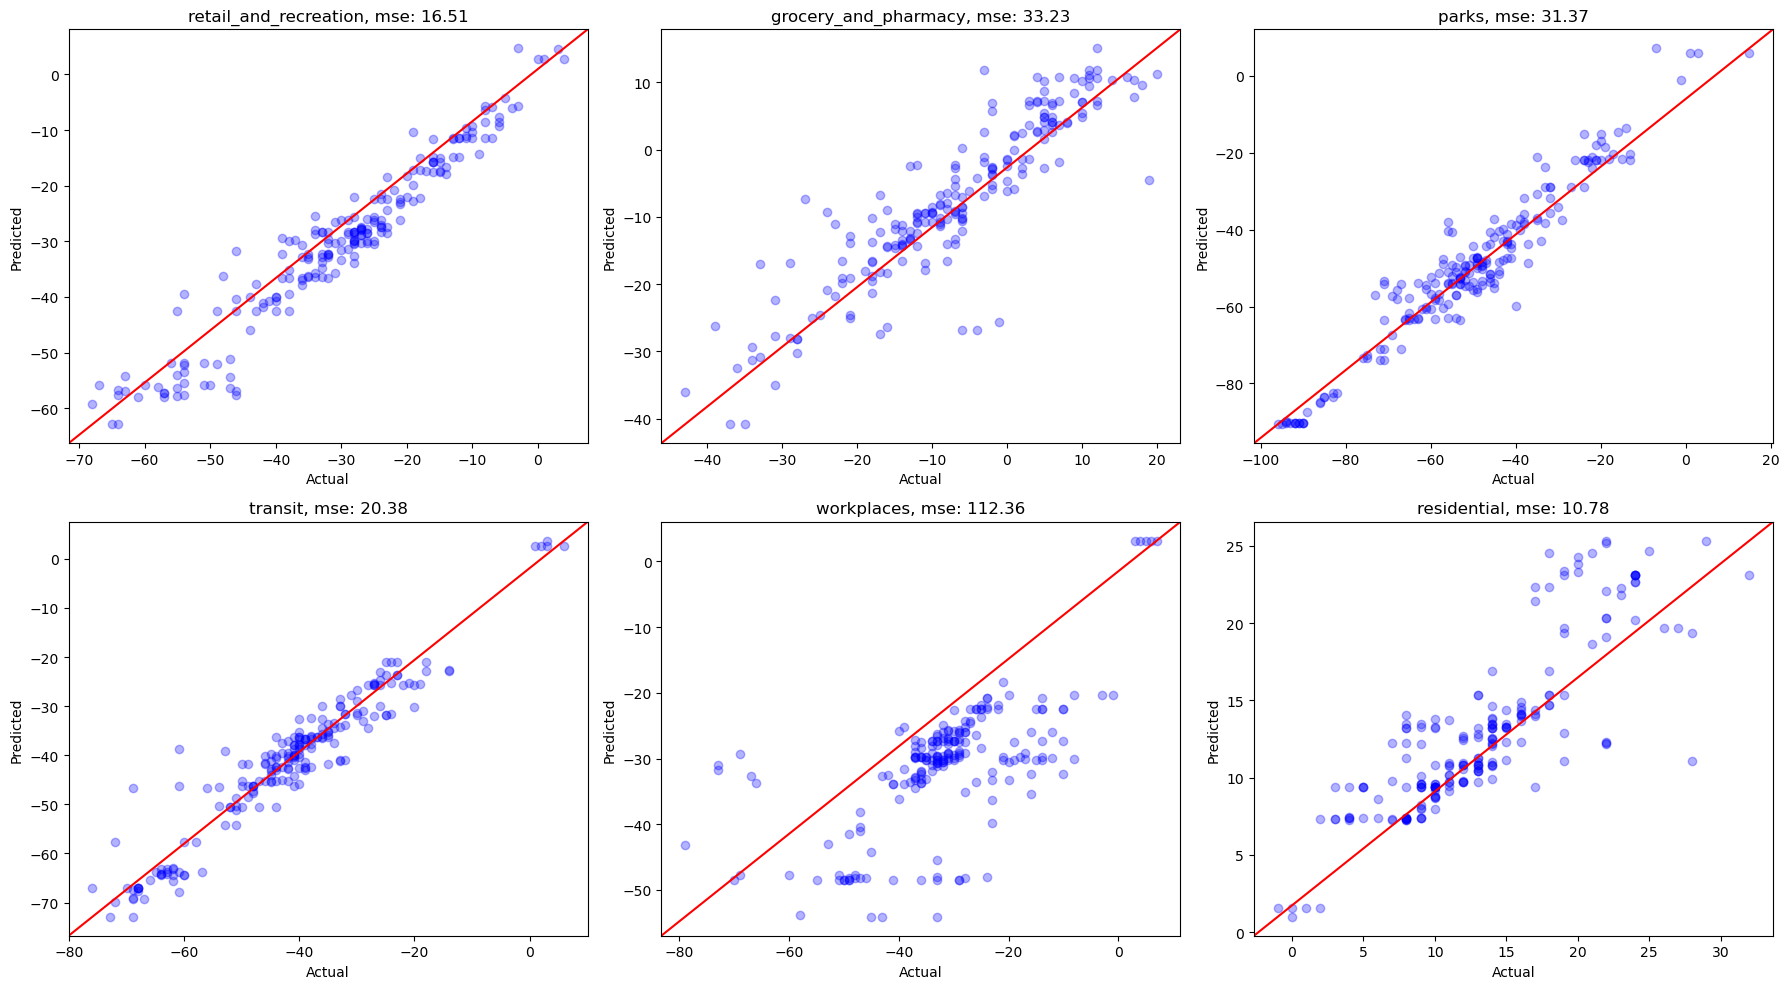

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_xgb_tuning = [y_pred_xgb_tuning_values, y_test]

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[i], y_pred_xgb_tuning_values[i], c='blue', alpha=0.3)
    ax.plot([y_test[i].min(), y_test[i].max()], [y_test[i].min(), y_test[i].max()], c='red', transform=ax.transAxes)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(mobility_column[i] + ", mse: %.2f" % mse_xgb_tuning_values[i])

plt.tight_layout()
plt.show()

### Performa Model

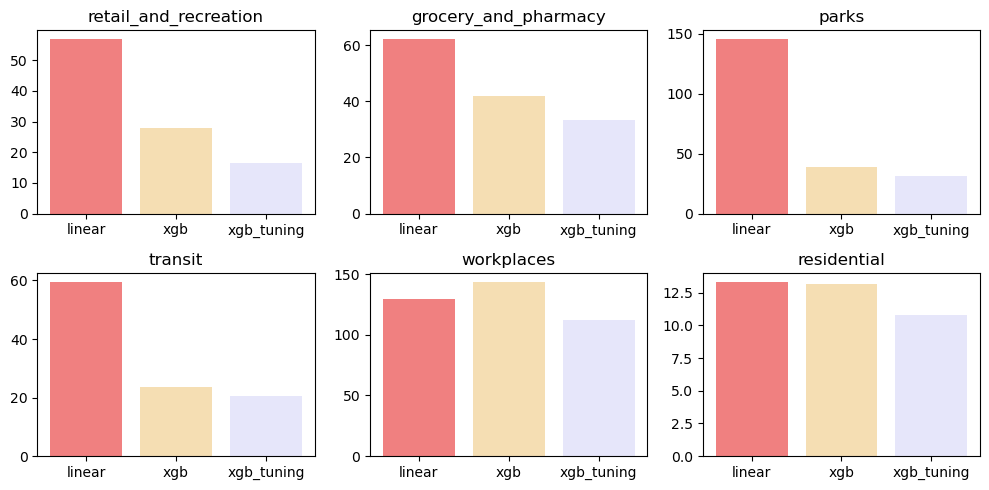

In [46]:
fig, ax = plt.subplots(2,3, figsize=(10, 5))

colors = ['lightcoral', 'wheat', 'lavender'] 

for i in range(len(mse_linear_values)):
    ax[i//3, i%3].bar(['linear', 'xgb', 'xgb_tuning'], [mse_linear_values[i], mse_xgb_values[i], mse_xgb_tuning_values[i]], color=colors)
    ax[i//3, i%3].set_title(mobility_column[i])

plt.tight_layout()
plt.show()

In [47]:
mse_table = pd.DataFrame({'linear': mse_linear_values, 'xgb': mse_xgb_values, 'xgb_tuning': mse_xgb_tuning_values}, index=mobility_column)
mse_table

linear         xgb  xgb_tuning
retail_and_recreation   56.896685   27.828166   16.506339
grocery_and_pharmacy    62.190291   41.862614   33.226408
parks                  145.614830   39.292409   31.366192
transit                 59.617229   23.763470   20.378411
workplaces             129.549104  143.786291  112.362952
residential             13.352074   13.144491   10.777151

Diatas menunjukkan tabel prediksi kolom mobilitas menggunakan kolom covid yang telah terpilih sebelumnya. Terdapat penurunan nilai MSE pada tiap pergantian model yang artinya model dapat memprediksi dengan lebih baik.

## Prediksi Polusi Udara Berdasarkan Data Mobilitas

In [48]:
Air_Quality_column2

['pm10', 'o3', 'no2', 'so2', 'co']

In [49]:
X = df[["retail_and_recreation", "grocery_and_pharmacy", "parks", "transit", "workplaces", "residential"]] 
y_1 = df['pm10']
y_2 = df['o3']
y_3 = df['no2']
y_4 = df['so2']
y_5 = df['co']

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X, y_1, test_size=0.3, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X, y_2, test_size=0.3, random_state=42)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X, y_3, test_size=0.3, random_state=42)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X, y_4, test_size=0.3, random_state=42)
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X, y_5, test_size=0.3, random_state=42)

In [50]:
X_train = [X_1_train, X_2_train, X_3_train, X_4_train, X_5_train]
y_train = [y_1_train, y_2_train, y_3_train, y_4_train, y_5_train]
X_test = [X_1_test, X_2_test, X_3_test, X_4_test, X_5_test]
y_test = [y_1_test, y_2_test, y_3_test, y_4_test, y_5_test]

### Linear Regression

In [51]:
regressors = [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()]

mse_linear_values = []
y_pred_linear_values = []

for i in range(len(regressors)):
    regressors[i].fit(X_train[i], y_train[i])
    y_pred = regressors[i].predict(X_test[i])
    y_pred_linear_values.append(y_pred)
    mse = mean_squared_error(y_test[i], y_pred)
    mse_linear_values.append(mse)
    print(f"Mean squared error for {Air_Quality_column2[i]}: %.2f" % mse)

Mean squared error for pm10: 144.22
Mean squared error for o3: 241.69
Mean squared error for no2: 109.85
Mean squared error for so2: 144.71
Mean squared error for co: 20.12


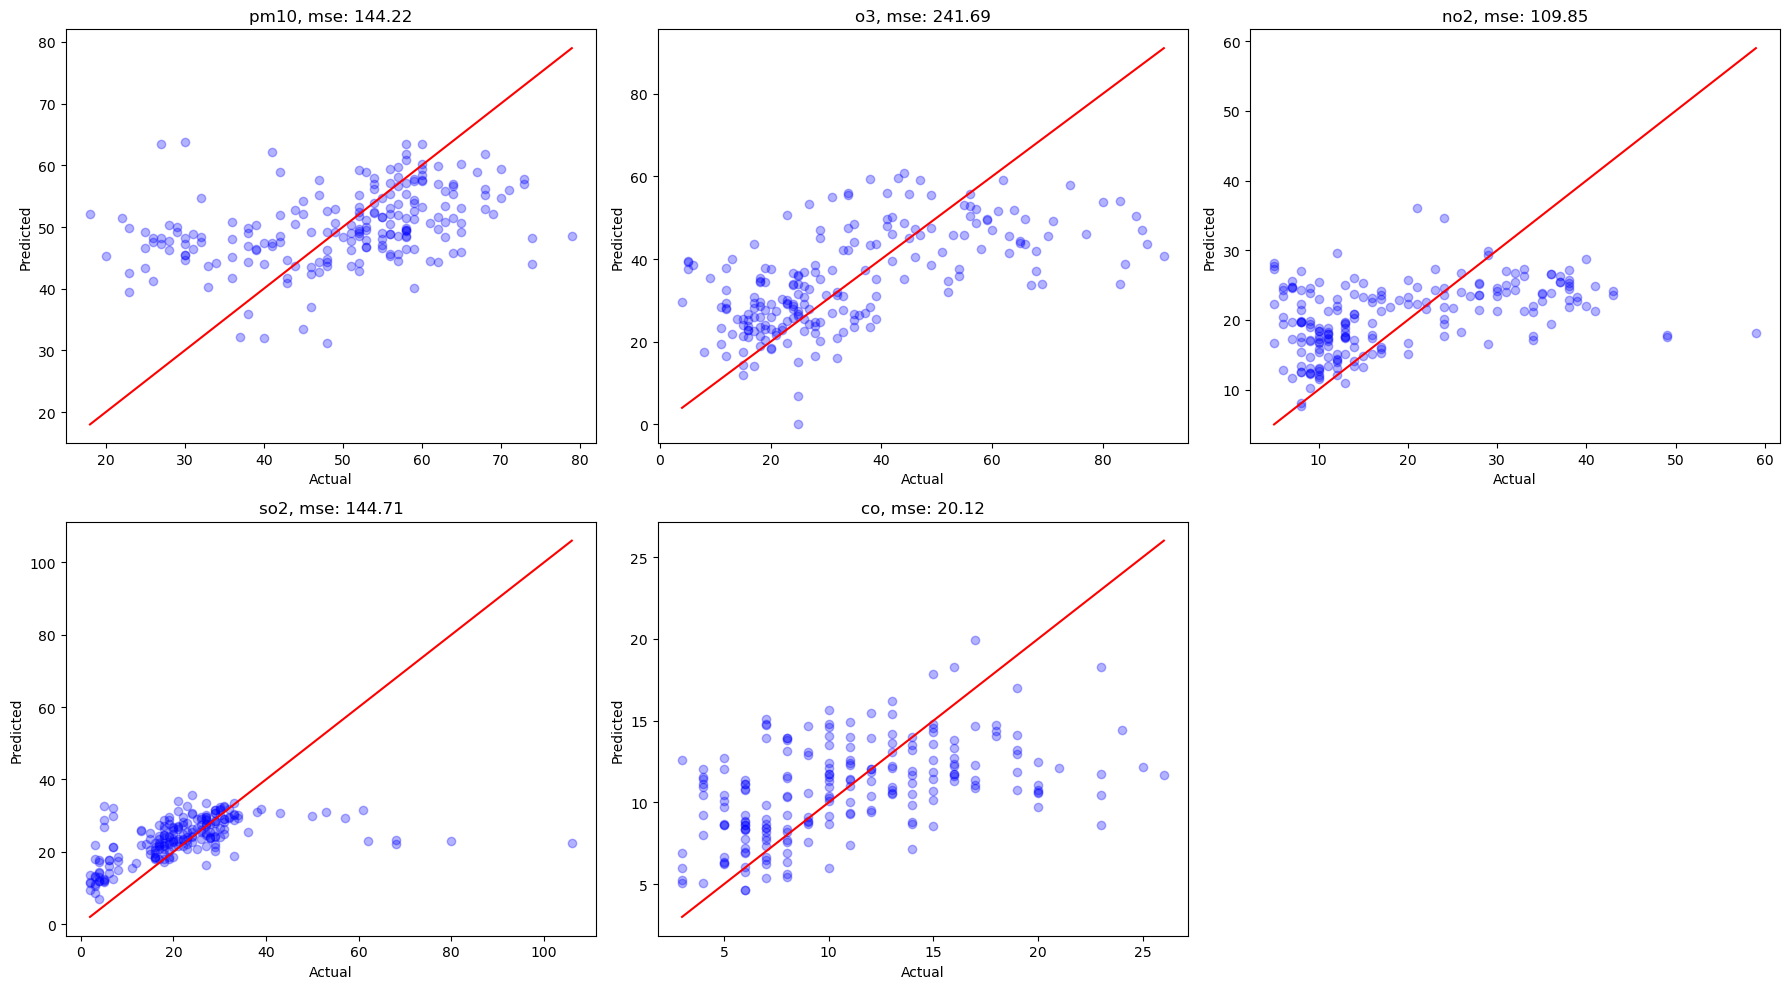

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_linear = [y_pred_linear_values, y_test]

for i, ax in enumerate(axes.flat):
    if i >= (5):
        ax.axis('off')
        break  # Ignore the sixth subplot
    ax.scatter(y_test[i], y_pred_linear_values[i], c='blue', alpha=0.3)
    ax.plot([y_test[i].min(), y_test[i].max()], [y_test[i].min(), y_test[i].max()], c='red')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(Air_Quality_column2[i] + ", mse: %.2f" % mse_linear_values[i])

plt.tight_layout()
plt.show()

### XGBoost

In [53]:
regressors = [XGBRegressor(), XGBRegressor(), XGBRegressor(), XGBRegressor(), XGBRegressor()]

mse_xgb_values = []
y_pred_xgb_values = []

for i in range(len(regressors)):
    regressors[i].fit(X_train[i], y_train[i])
    y_pred = regressors[i].predict(X_test[i])
    y_pred_xgb_values.append(y_pred)
    mse = mean_squared_error(y_test[i], y_pred)
    mse_xgb_values.append(mse)
    print(f"Mean squared error for {Air_Quality_column2[i]}: %.2f" % mse)


Mean squared error for pm10: 152.70
Mean squared error for o3: 264.66
Mean squared error for no2: 87.68
Mean squared error for so2: 107.97
Mean squared error for co: 23.04


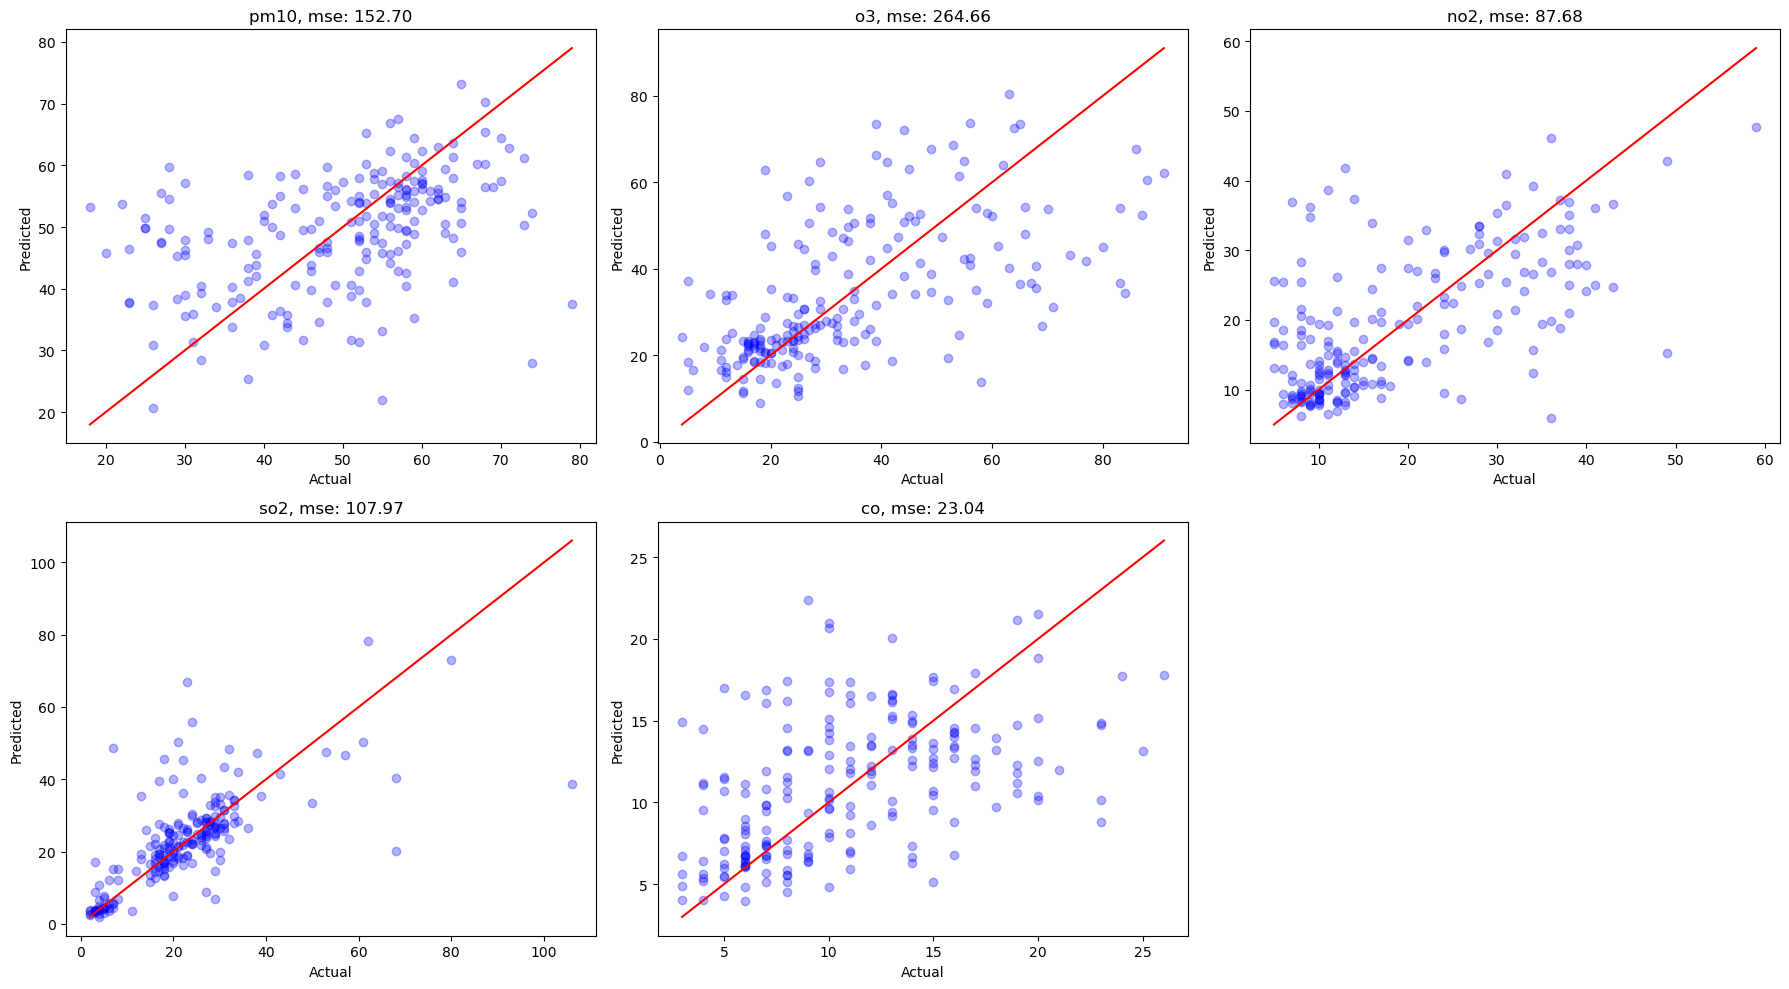

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_xgb = [y_pred_xgb_values, y_test]

for i, ax in enumerate(axes.flat):
    if i >= (5):
        ax.axis('off')
        break  # Ignore the sixth subplot
    ax.scatter(y_test[i], y_pred_xgb_values[i], c='blue', alpha=0.3)
    ax.plot([y_test[i].min(), y_test[i].max()], [y_test[i].min(), y_test[i].max()], c='red')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(Air_Quality_column2[i] + ", mse: %.2f" % mse_xgb_values[i])

plt.tight_layout()
plt.show()

### XGBoost With Hyperparameter Tuning

In [55]:
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
}

mse_xgb_tuning_values = []
y_pred_xgb_tuning_values = []

for i in range(len(regressors)):
    grid_search = GridSearchCV(regressors[i], param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train[i], y_train[i])
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test[i])
    y_pred_xgb_tuning_values.append(y_pred)
    mse = mean_squared_error(y_test[i], y_pred)
    mse_xgb_tuning_values.append(mse)
    print(f"Best parameters for {Air_Quality_column2[i]}: {grid_search.best_params_}")
    print(f"Mean squared error for {Air_Quality_column2[i]}: {mse:.2f}")

Best parameters for pm10: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Mean squared error for pm10: 144.19
Best parameters for o3: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Mean squared error for o3: 199.77
Best parameters for no2: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
Mean squared error for no2: 73.29
Best parameters for so2: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}
Mean squared error for so2: 88.89
Best parameters for co: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Mean squared error for co: 19.75


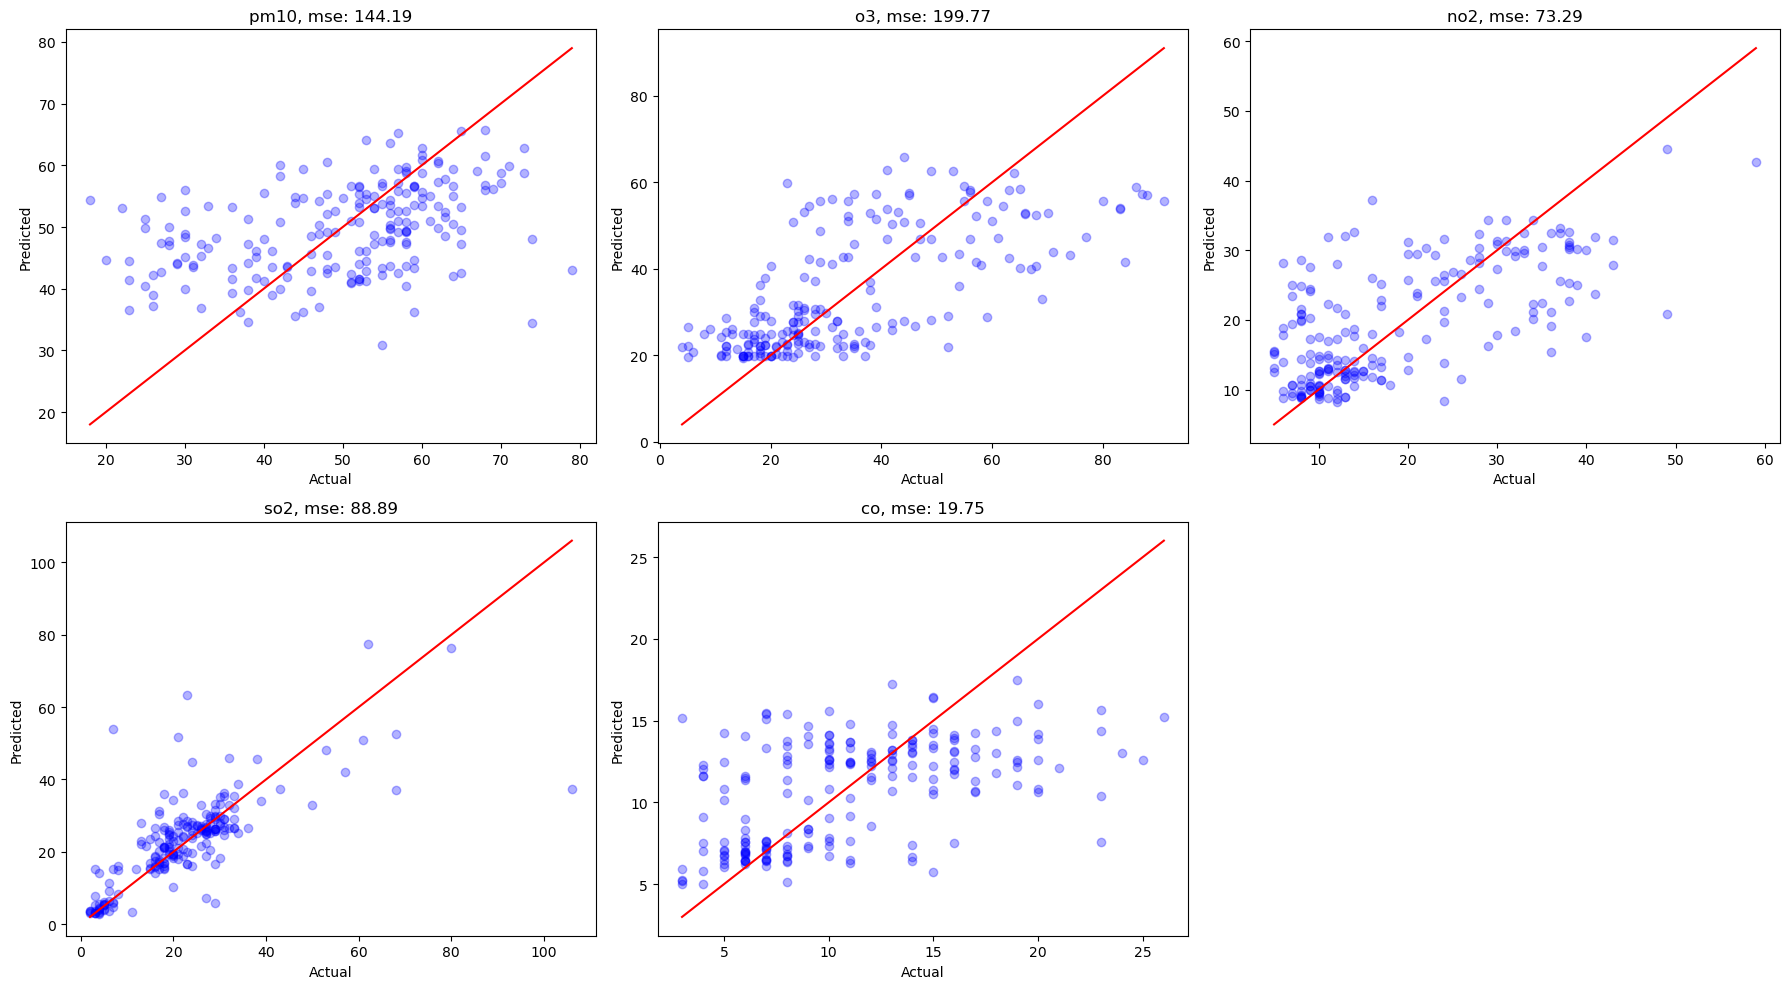

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_xgb_tuning = [y_pred_xgb_tuning_values, y_test]

for i, ax in enumerate(axes.flat):
    if i >= (5):
        ax.axis('off')
        break  # Ignore the sixth subplot
    ax.scatter(y_test[i], y_pred_xgb_tuning_values[i], c='blue', alpha=0.3)
    ax.plot([y_test[i].min(), y_test[i].max()], [y_test[i].min(), y_test[i].max()], c='red')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(Air_Quality_column2[i] + ", mse: %.2f" % mse_xgb_tuning_values[i])

plt.tight_layout()
plt.show()

### Performa Model

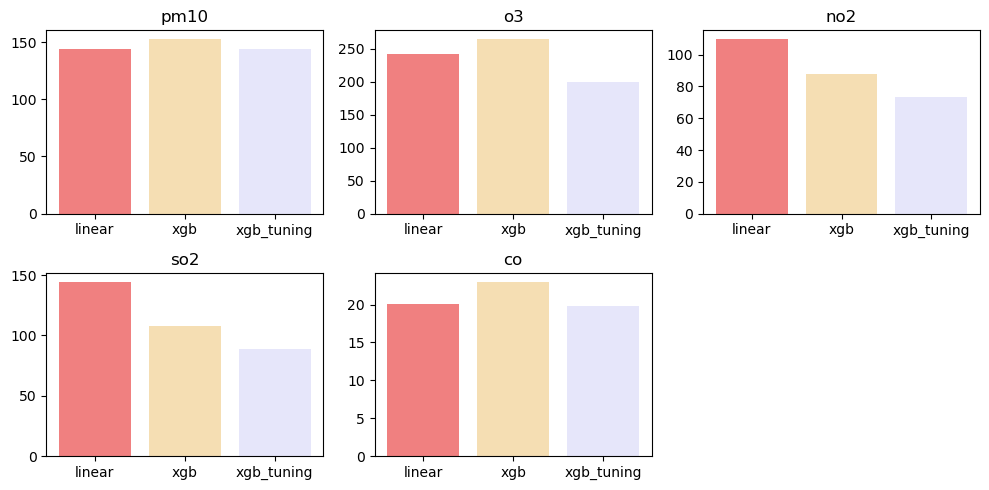

In [57]:
fig, ax = plt.subplots(2,3, figsize=(10, 5))

colors = ['lightcoral', 'wheat', 'lavender']

for i in range(len(mse_linear_values)):
    ax[i//3, i%3].bar(['linear', 'xgb', 'xgb_tuning'], [mse_linear_values[i], mse_xgb_values[i], mse_xgb_tuning_values[i]], color=colors)
    ax[i//3, i%3].set_title(Air_Quality_column2[i])

if len(Air_Quality_column2) < 6:
    for j in range(len(Air_Quality_column2), 6):
        ax[j // 3, j % 3].axis('off')
        
plt.tight_layout()
plt.show()

In [58]:
mse_table = pd.DataFrame({'linear': mse_linear_values, 'xgb': mse_xgb_values, 'xgb_tuning': mse_xgb_tuning_values}, index=Air_Quality_column2)
mse_table

linear         xgb  xgb_tuning
pm10  144.223763  152.697195  144.186031
o3    241.690309  264.664884  199.772687
no2   109.849908   87.676533   73.291859
so2   144.709981  107.974694   88.890529
co     20.121542   23.042128   19.752860